In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import json
import os
import sys
import boto3
import yaml

sys.path.append("..")
from utils.config_handler import load_config
from utils.misc import decode_base64_image, display_images

In [3]:
config = load_config(os.path.join("..", "config", "config.yaml"))

boto_session = boto3.Session(
    profile_name=config.profile_name, region_name=config.region_name
)
sm_client = boto_session.client("sagemaker")
sm_runtime_client = boto_session.client("sagemaker-runtime")

## Generating Images

In [4]:
def make_prompt(prompt: str) -> str:
    prompt_prefix = "RAW photo"
    prompt_suffix = "(high detailed skin:1.2), 8k uhd, dslr, soft lighting, high quality, film grain, Fujifilm XT3"
    return ", ".join([prompt_prefix, prompt, prompt_suffix]).strip()


def make_negative_prompt(negative_prompt: str) -> str:
    negative_prefix = "(deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime:1.4), \
    text, close up, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, \
    extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, \
    bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, \
    extra arms, extra legs, fused fingers, too many fingers, long neck"

    return (
        ", ".join([negative_prefix, negative_prompt]).strip()
        if len(negative_prompt) > 0
        else negative_prefix
    )

In [5]:
PROMPT = "a korean woman wearing a white t-shirt and jeans"
HEIGHT = 768
WIDTH = 512
NEGATIVE_PROMPT = ""
SEED = 42
CROSS_ATTENTION_SCALE = 0.75

In [6]:
%%time
payload = {
    "prompt": make_prompt(PROMPT),
    "height": HEIGHT,
    "width": WIDTH,
    "num_inference_steps": 50,
    "guidance_scale": 7.0,
    "negative_prompt": make_negative_prompt(NEGATIVE_PROMPT),
    "num_images_per_prompt": 2,
    "seed": SEED,
    "cross_attention_scale": CROSS_ATTENTION_SCALE,
}

response = sm_runtime_client.invoke_endpoint(
    EndpointName=config.endpoint_name,
    ContentType="application/json",
    Accept="application/json",
    Body=json.dumps(payload),
)
response = json.loads(response["Body"].read().decode("utf-8"))

CPU times: user 14.3 ms, sys: 4.23 ms, total: 18.5 ms
Wall time: 24.5 s


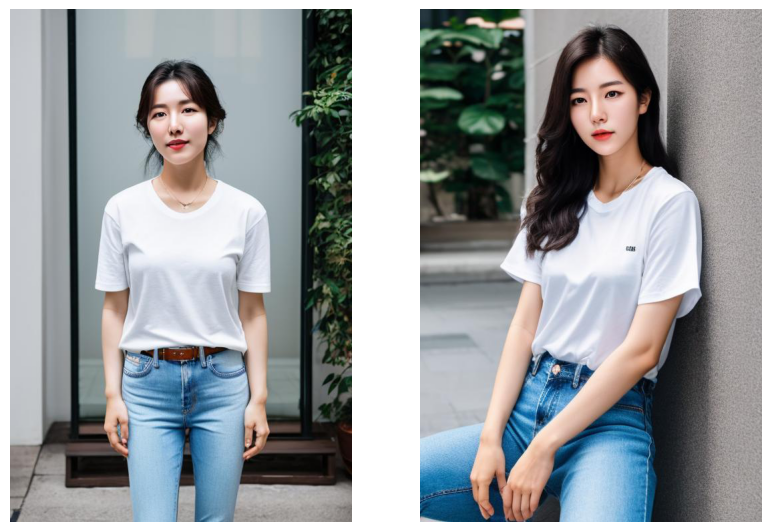

In [7]:
images = [decode_base64_image(image) for image in response["generated_images"]]
display_images(images)

In [8]:
_ = sm_client.delete_endpoint_config(EndpointConfigName=config.endpoint_name)
_ = sm_client.delete_endpoint(EndpointName=config.endpoint_name)